## PyTorch 학습 레벨 2 - 003
---

### 순서
- Tensor
- Augograd
- _~~DataSet, DataLoader~~_
- Transform

### DataSet, DataLoader
[여기](https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html)
- 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있음
- 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습과 분리하는 것이 이상적
- `torch.utils.data.Dataset`, `torch.utils.data.DataLoader` 로 데이터를 효율적으로 관리
- `DataSet`은 샘플과 label(정답)을 저장, `DataLoader`는 DataSet을 쉽게 접근할 수 있게 iterable로 감싸는 작업 수행
- 가장 많이 사용하는 [이미지 데이터셋](https://pytorch.org/vision/stable/datasets.html)

#### Load DataSet
- `TorchVision` 에서 [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist) 데이터셋 불러오는 예제
- Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 구성
- 흑백(grayscale)의 28x28 이미지와 10개 분류(class) 중 하나인 정답(label)으로 구성

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.76MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 109kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 2.04MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.1MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



- 100MB 넘는 데이터가 없기 때문에, github에 저장

#### 데이터셋을 순회하고 시각화
- Dataset 에 리스트(list)처럼 직접 접근(index) 가능. training_data[index]. matplotlib 을 사용하여 학습 데이터의 일부를 시각화

In [4]:
labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
} # 0~9번까지의 이미지는 위와 같이 정해져 있다

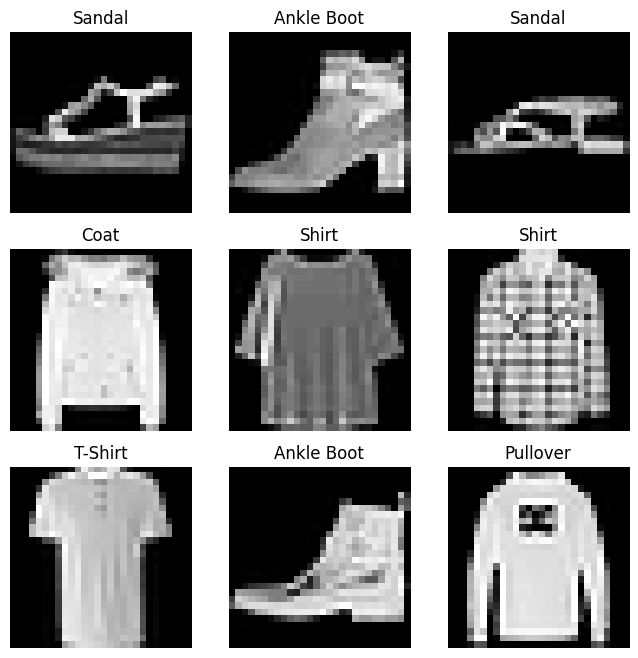

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

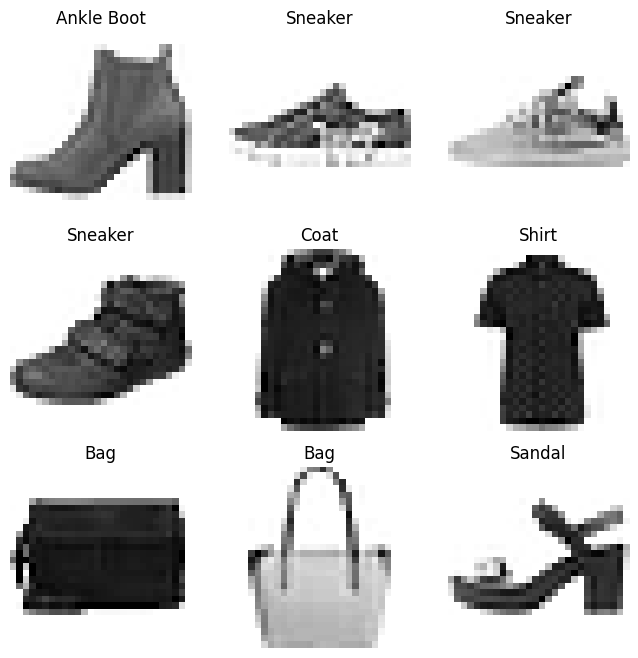

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray_r')
plt.show()

#### 파일에서 사용자 정의 데이터셋 만들기
- 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현
- `__init__`, `__len__`, and `__getitem__`. 아래 구현을 살펴보면 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 `annotations_file csv` 파일에 별도로 저장

In [8]:
import os
import pandas as pd
from torchvision.io import read_image

In [10]:
class CustomImageDataset(Dataset):
    # 데이터셋 객체가 생성될 때 호출 및 초기화
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)   # annotations_file(.csv)에서 이미지 레이블 정보를 로드
        self.img_dir = img_dir          # 이미지 파일이 위치한 디렉터리 경로
        self.transform = transform      # 이미지에 적용할 변환 함수 (예: 데이터 증강)
        self.target_transform = target_transform    # 레이블에 적용할 변환 함수

    # 데이터셋의 총 길이(샘플의 개수)를 리턴
    def __len__(self):
        return len(self.img_labels) # 레이블 파일의 행 수, 즉 데이터셋의 샘플 개수

    # 인덱스를 받아 해당 데이터 샘플을 리턴
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])     # 이미지 파일 경로
        image = read_image(img_path)        # 이미지 로드드
        label = self.img_labels.iloc[idx, 1]    # 해당 이미지의 레이블을 얻음
        if self.transform:              # 변환 함수가 주어졌다면 이미지에 적용
            image = self.transform(image)
        if self.target_transform:       # 레이블 변환 함수가 주어졌다면 레이블에 적용
            label = self.target_transform(label)
        return image, label     # 변환된 이미지와 레이블 리턴

##### `__init__`
- `__init__` 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행

labels.csv 파일은 다음과 같습니다: 
```txt
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

##### `__len__`

`__len__` 함수는 데이터셋의 샘플 개수를 리턴

##### `__getitem__`

- `__getitem__` 함수는 주어진 인덱스 `idx` 에 해당하는 샘플을 데이터셋에서 불러오고 리턴
- 인덱스 기반, 디스크에서 이미지의 위치를 식별 `read_image`함수로 이미지를 텐서로 변환
- `self.img_labels`의 csv 데이터로부터 해당 label 가져옴
- transform(변형) 함수들을 호출, 텐서 이미지와 라벨을 Dictionary 형태로 리턴

#### DataLoader로 학습용 데이터 준비
- `Dataset`은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일 수행
- 일반적으로 샘플들을 “미니배치(minibatch)”로 전달, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막음
- Python의 multiprocessing 을 사용하여 데이터 검색 속도를 향상 기대
- `DataLoader`는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iteratable)

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x287482cc290>,
 <torch.utils.data.dataloader.DataLoader at 0x28748418450>)

#### DataLoader를 통해 순회하기(iterate)
- ``DataLoader`` 에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)
- 각각 ``batch_size=64`` 의 특징(feature)과 정답(label)을 포함하는 `train_features` 와 `train_labels` 의 묶음(batch)을 리턴
- 데이터 불러오기 순서를 보다 세밀하게(finer-grained) 제어하려면 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) 사용 권장

##### 배치사이즈
- 실험과 모델에 따라 선택되는 하이퍼파라미터
- 배치 크기(batch size)는 딥러닝 모델의 학습에서 한 번에 네트워크를 통해 전달되는 데이터 샘플의 수를 의미
- 배치 크기가 클수록 병렬 처리가 가능, 계산 효율성 면에서 유리. 너무 큰 배치 크기는 과적합(overfitting) 문제 발생가능
- 배치 크기는 학습률(learning rate)과 같은 다른 하이퍼파라미터와 밀접하게 연관
    - 배치 크기가 크면 학습률을 더 크게 설정하는 것이 일반적
- 보통 32, 64, 128, 256 등 다양한 배치 크기를 시도하여 가장 적합한 값 도출이 최우선

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


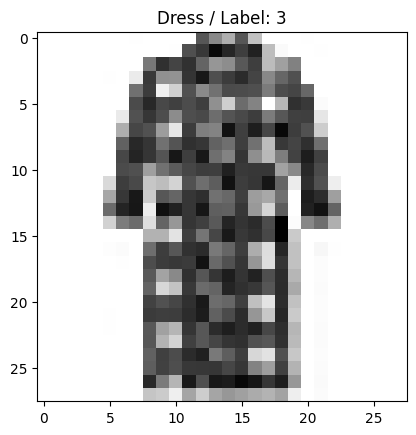

In [28]:
# 이미지와 정답(label)을 표시
img_idx = 0

# train_dataloader에서 첫 번째 배치 가져옴. train_features는 이미지, train_labels는 레이블
train_features, train_labels = next(iter(train_dataloader))  
print(f"Feature batch shape: {train_features.size()}")       # train_features(입력 이미지 배치)의 크기
print(f"Labels batch shape: {train_labels.size()}")         # train_labels(레이블 배치)의 크기

# 첫 번째 이미지 샘플을 선택
img = train_features[img_idx].squeeze()       # squeeze()로 불필요한 차원을 제거
label = train_labels[img_idx]                 # 첫 번째 레이블을 선택
plt.imshow(img, cmap='gray_r')
plt.title(f'{labels_map[int(label)]} / Label: {label}')
plt.show()

### 순서
- Tensor
- Augograd
- DataSet, DataLoader
- _~~Transform~~_